## Chapter 6: Eligibility Traces

Eligibility traces are one of the basic mechanisms of reinforcement learning that aims to bridge Temporal Difference (TD) and Monte-Carlo (MC). 

Combined with TD methods such as Q-learning or SARSA, it can obtain a more general method that may learn more efficiently.



### TD$(\lambda)$

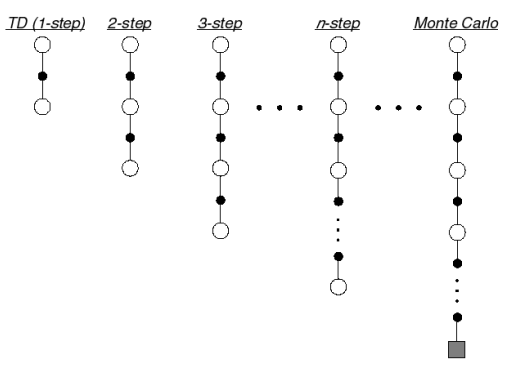

In Temporal-Difference value prediction, return $G_t$ is bootstrapped as the following:
</br>
</br>
<font size="3">
$$\begin{align}
G_t = R_{t+1} + \gamma R_{t+2} + \cdots + \gamma^{T-1} R_T = R_{t+1} + \gamma V(S_{t+1})
\end{align}$$
</font>

Return of state $S_t$ in MC is calculated at the end of the episode, and boostrapped return in TD is calculated after one step of $S_t$. 

#### n-step TD Prediction

We can think of intermediate version of return of TD and MC, that boostrapping is performed using multiple steps of returns. 
</br>
</br>
<font size="3">
$$\begin{align}
G_t^{(n)} = R_{t+1} + \gamma R_{t+2} + \cdots + \gamma^{n-1}R_{t+n} + \gamma^{n}V(S_{t+n})
\end{align}$$
</font>
which is named **n-step return**.

Using n-step return, n-step TD prediction can be done.
</br>
</br>
<font size="3">
$$\begin{align}
V(S_t) = V(S_t) + \alpha(G_t^{(n)} - V(S_t))
\end{align}$$
</font>


#### $\lambda$ - return

We can average n-step returns over different n, interrelating TD and Monte-Carlo methods.
$\lambda$-return is weighted average of all n-step returns $G_t^{(n)}$ with $\lambda \in [0, 1]$ as the following:
</br>
</br>
<font size="3">
$$\begin{align}
G_t^{(\lambda)} = (1-\lambda) \sum_{n=1}^{T-t-1}[\lambda^{n-1}G_t^{(t + n)}] + \lambda^{T-t-1}G_t^T \\
= (1-\lambda)G_t^{(1)} + (1-\lambda)\lambda G_t^{(2)} + \cdots + \lambda^{T-t-1} G_t^{T}&
\end{align}$$
</font>

last term of $G_t^{(\lambda)}$ is set as $\lambda^{T-t-1} G_t^{T}$ because weights of n-step returns have to sum to 1. $\lambda = 0$ is equivalent to TD-target, and $\lambda = 1$ is equivalent to Monte-Carlo return. 



### Forward View of TD$(\lambda)$

### Backward View of TD$(\lambda)$